In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
from gaussian_processes_util import plot_gp
import numpy as np


def kernel(X1, X2, l=1.0, sigma_f=1.0):
    ''' Isotropic squared exponential kernel. Computes a covariance matrix from points in X1 and X2. Args: X1: Array of m points (m x d). X2: Array of n points (n x d). Returns: Covariance matrix (m x n). '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


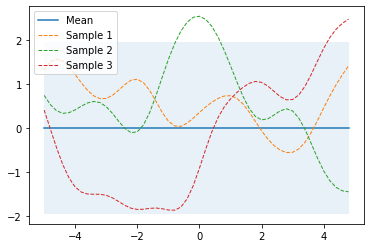

In [2]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior 
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# np.disp(samples.reshape(-1, 1))

# Plot GP mean, confidence interval and samples
plot_gp(mu, cov, X, samples=samples)

In [3]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the suffifient statistics of the GP posterior predictive distribution from m training data X_train and Y_train and n new inputs X_s. Args: X_s: New input locations (n x d). X_train: Training locations (m x d). Y_train: Training targets (m x 1). l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. sigma_y: Noise parameter. Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
 
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    
    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

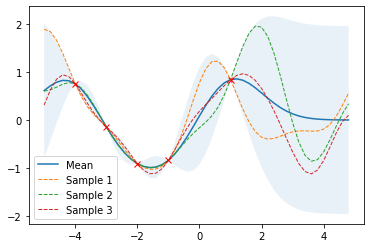

In [4]:
# Noise free training data 
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

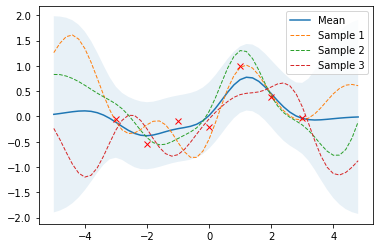

In [5]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

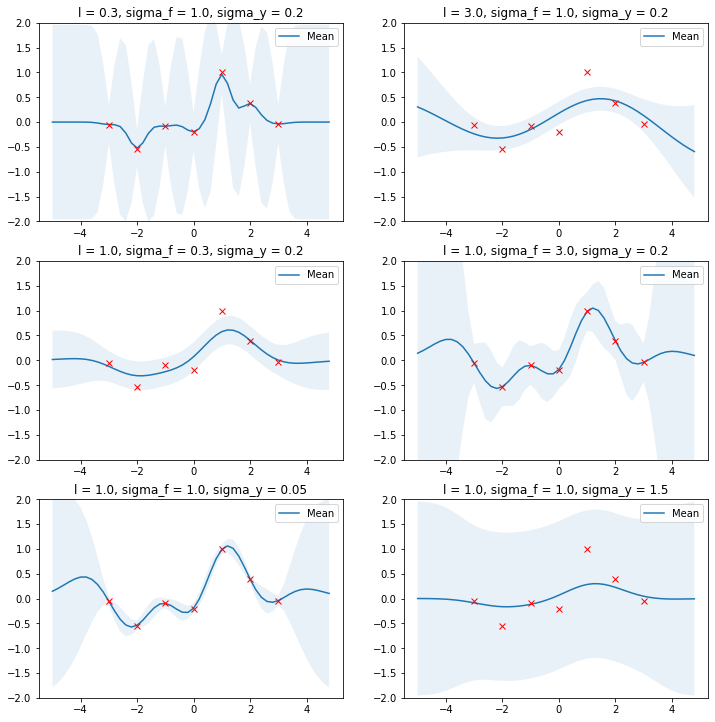

In [6]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
    plt.ylim(-2, 2)

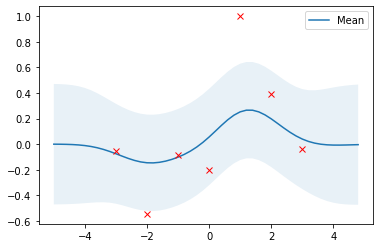

In [7]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    ''' Returns a function that computes the negative marginal log- likelihood for training data X_train and Y_train and given noise level. Args: X_train: training locations (m x d). Y_train: training targets (m x 1). noise: known noise level of Y_train. naive: if True use a naive implementation of Eq. (7), if False use a numerically more stable implementation. Returns: Minimization objective. '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
